In [1]:
import pandas as pd
import numpy as np
import cv2 
import tensorflow as tf

import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
# unzip data.zip
import zipfile
zip_ref = zipfile.ZipFile('data.zip', 'r')
zip_ref.extractall('.')
zip_ref.close()

In [3]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

Sequences
0  MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1  MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2  MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3  MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4  MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...

In [4]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    return Codone(df)

In [5]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [6]:
class Codone:
    class Iterator:
        def __init__(self, df):
            self.df = df
            self.index = 0
            self.max_index = df.shape[0]
            self.iterator = iter(range(0))
        def __next__(self):
            try:
                return self.iterator.__next__()
            except StopIteration:
                if self.index == self.max_index:
                    raise StopIteration
                row = self.df.iloc[self.index,:][0]
                self.index += 1
                self.iterator = iter(seq_to3(row))
                return self.__next__()

    def __init__(self, df):
        self.df = df

    def __iter__(self):
        return Codone.Iterator(self.df)

In [7]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [8]:
##########################################################################

In [9]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    unique_codones = set(flat_codones)
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary

def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [10]:
dictionary = make_dictionary(all_codones)

In [11]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [12]:
#################################################################

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [37]:
torch.manual_seed(3)

In [38]:
class TorchSkipGramModel(nn.Module):
    def __init__(self, vocab_size, embed_size, batch_size, num_sampled):
        super(TorchSkipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.u_embeddings = nn.Embedding(self.vocab_size, self.embed_size, sparse=True)
        self.v_embeddings = nn.Embedding(self.vocab_size, self.embed_size, sparse=True)
        self.u_embeddings.weight.data.uniform_(-1.0, 1.0)
        self.v_embeddings.weight.data.zero_()
      
    def forward(self, pos_u, pos_v, neg_v=None):
        emb_u = self.u_embeddings(torch.LongTensor(pos_u))
        emb_v = self.v_embeddings(torch.LongTensor(pos_v)).squeeze()
        score = torch.mul(emb_u, emb_v).squeeze()
        score = torch.sum(score, dim=1)
        loss = F.logsigmoid(score)
    
        neg_embed_v  = self.v_embeddings(neg_v)
        neg_score = torch.bmm(neg_embed_v, emb_u.unsqueeze(2)).squeeze()
        neg_score = torch.sum(neg_score, dim=1)
        sum_log_sampled = F.logsigmoid(-1 * neg_score)
        loss += sum_log_sampled

        return -loss.mean()

In [39]:
VOCAB_SIZE = 9424
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = .9
NUM_TRAIN_STEPS = 100000
SKIP_STEP = 2000

model = TorchSkipGramModel(VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED)

In [40]:
#####################################################################

In [41]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [42]:
import random

def make_neg_v(dictionary, center):
    return torch.LongTensor(torch.from_numpy(np.random.choice(list(dictionary.values()), 
                                                              size=(BATCH_SIZE, NUM_SAMPLED))))

In [43]:
writer = SummaryWriter(comment='codones_embedding_training')

In [44]:
def train_model(model, dictionary, batch_gen, num_train_steps, learning_rate, skip_step, path_to_pretrained_model=None):
    make_dir('checkpoints')
    
    # pretrained model must be .pth file
    if path_to_pretrained_model is not None:
        model.load_state_dict(torch.load(path_to_pretrained_model))

    model.train()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    total_loss = 0.0
    
    for index in range(num_train_steps):
        centers_idxs, contexts_idxs = next(batch_gen)
        model.zero_grad()
        neg_v = make_neg_v(dictionary, centers_idxs)
        loss = model(centers_idxs, contexts_idxs, neg_v)
        loss.backward()
        optimizer.step()
        writer.add_scalar('loss', loss.data.item(), index)
        total_loss += loss.item()
        if (index + 1) % skip_step == 0:
            print('Average loss at step {}: {:5.1f}'.format(index, total_loss / skip_step))
            total_loss = 0.0
            save_name = 'checkpoints/step' + str(index) + '.pth'
            torch.save(model.state_dict(), save_name)

In [45]:
train_model(model, dictionary, batch_gen, NUM_TRAIN_STEPS, LEARNING_RATE, SKIP_STEP)

Average loss at step 1999:   1.3
Average loss at step 3999:   1.3
Average loss at step 5999:   1.0
Average loss at step 7999:   0.8
Average loss at step 9999:   0.9
Average loss at step 11999:   1.1
Average loss at step 13999:   1.1
Average loss at step 15999:   0.8
Average loss at step 17999:   0.6
Average loss at step 19999:   0.6
Average loss at step 21999:   1.0
Average loss at step 23999:   1.0
Average loss at step 25999:   0.8
Average loss at step 27999:   0.7
Average loss at step 29999:   0.6
Average loss at step 31999:   0.7
Average loss at step 33999:   0.7
Average loss at step 35999:   0.8
Average loss at step 37999:   0.7
Average loss at step 39999:   0.7
Average loss at step 41999:   0.6
Average loss at step 43999:   0.6
Average loss at step 45999:   0.4
Average loss at step 47999:   0.7
Average loss at step 49999:   0.8
Average loss at step 51999:   0.8
Average loss at step 53999:   0.8
Average loss at step 55999:   0.7
Average loss at step 57999:   0.7
Average loss at ste

In [46]:
final_embed_matrix = model.u_embeddings.weight.data.numpy()
writer.add_embedding(final_embed_matrix)
writer.close()

In [47]:
######################################################################################

In [49]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix)

In [50]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

x0         x1 codone
0  12.593821 -26.157835    LGR
1 -37.257229  33.003876    CGQ
2  -9.494302  16.769230    CEM
3  -0.685046  20.557726    EVY
4 -43.135334  24.156038    HXF

In [51]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

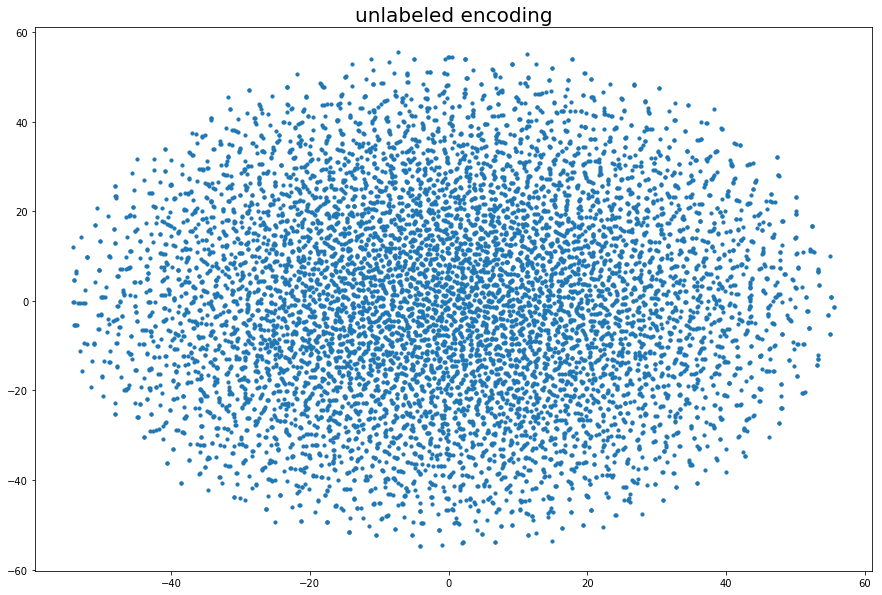

In [52]:
plot_tsne_df(tsne_df)

In [53]:
#####################################################################

In [54]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [55]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [56]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [57]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

acid  hydrophobicity        mass  number_of_atoms      volume
0  DMK       -1.833333  124.818600        20.000000  147.533333
1  LPN       -0.433333  108.125133        18.666667  131.166667
2  EII        1.833333  118.476400        21.000000  157.266667
3  PKM       -1.200000  118.827867        20.333333  148.066667
4  KFQ       -1.533333  134.491800        22.333333  167.433333

In [58]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

acid  hydrophobicity        mass  number_of_atoms      volume         x0  \
0  DMK       -1.833333  124.818600        20.000000  147.533333  27.713707   
1  LPN       -0.433333  108.125133        18.666667  131.166667 -12.511046   
2  EII        1.833333  118.476400        21.000000  157.266667 -29.164099   
3  PKM       -1.200000  118.827867        20.333333  148.066667  -2.205259   
4  KFQ       -1.533333  134.491800        22.333333  167.433333  -3.471355   

          x1  
0 -19.263371  
1   4.176071  
2  24.725737  
3  21.868996  
4 -28.437119

In [59]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

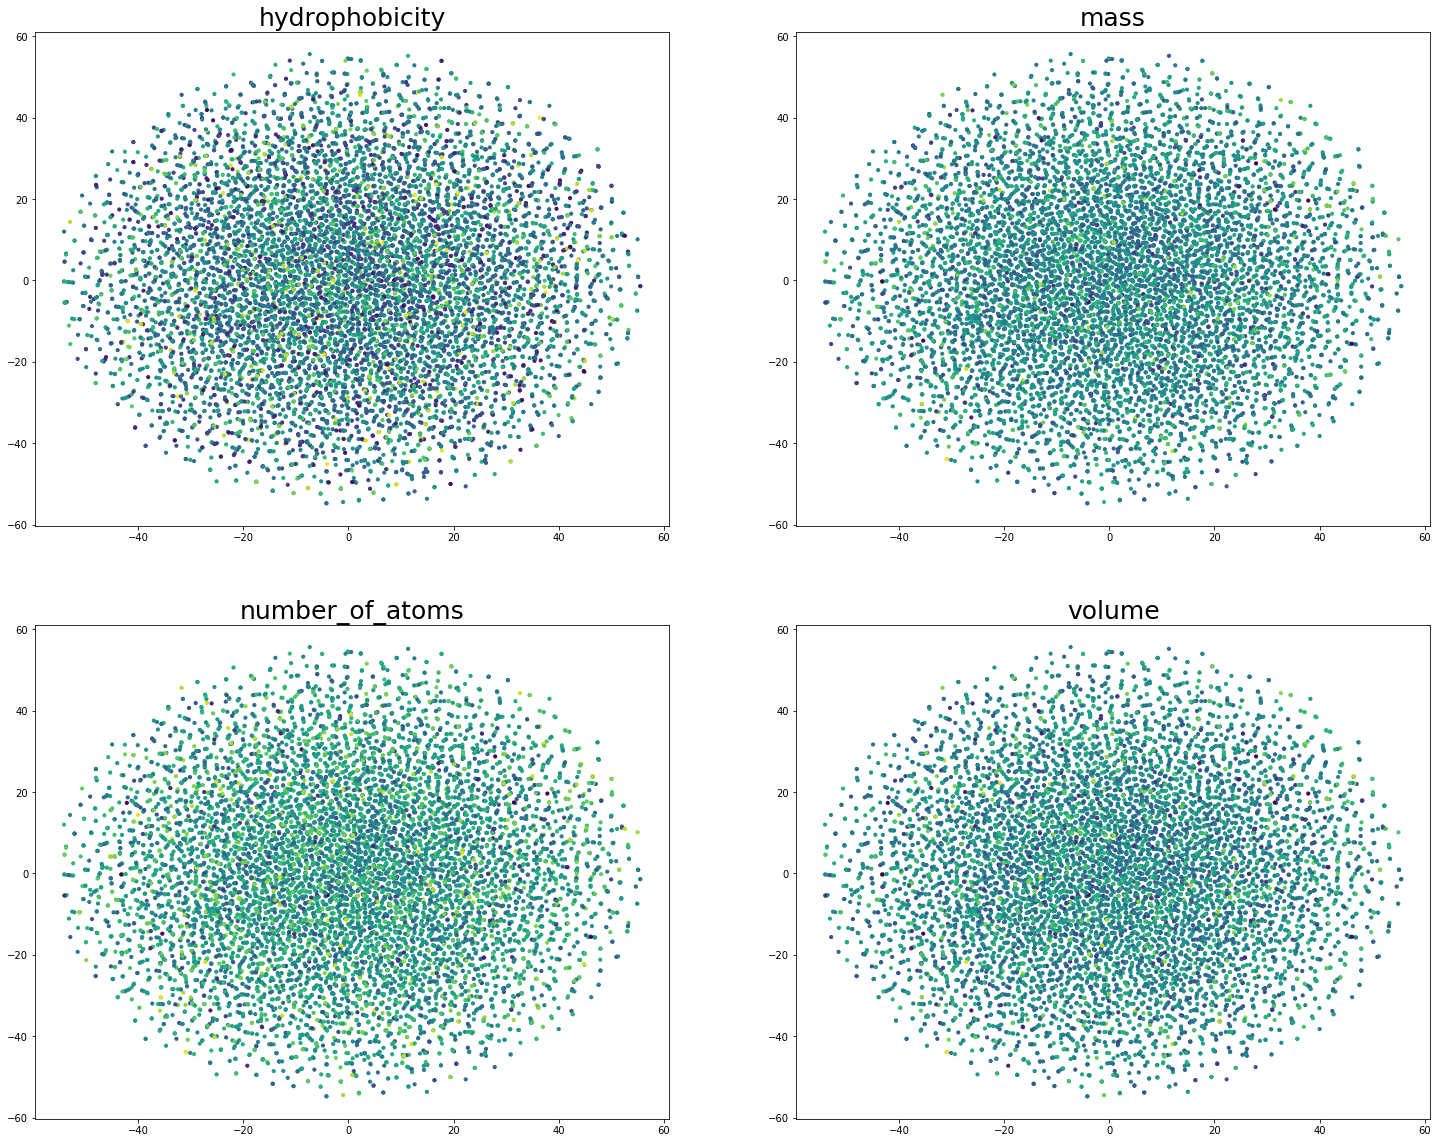

In [60]:
plot_embedding_properties(final_df)

In [61]:
######################

In [62]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

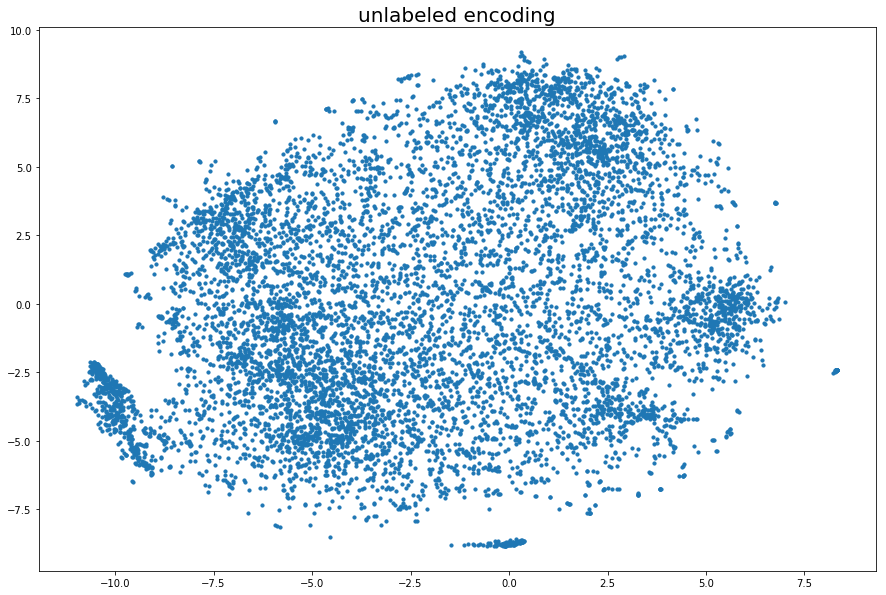

In [63]:
plot_tsne_df(gensim_tsne_df)

In [64]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

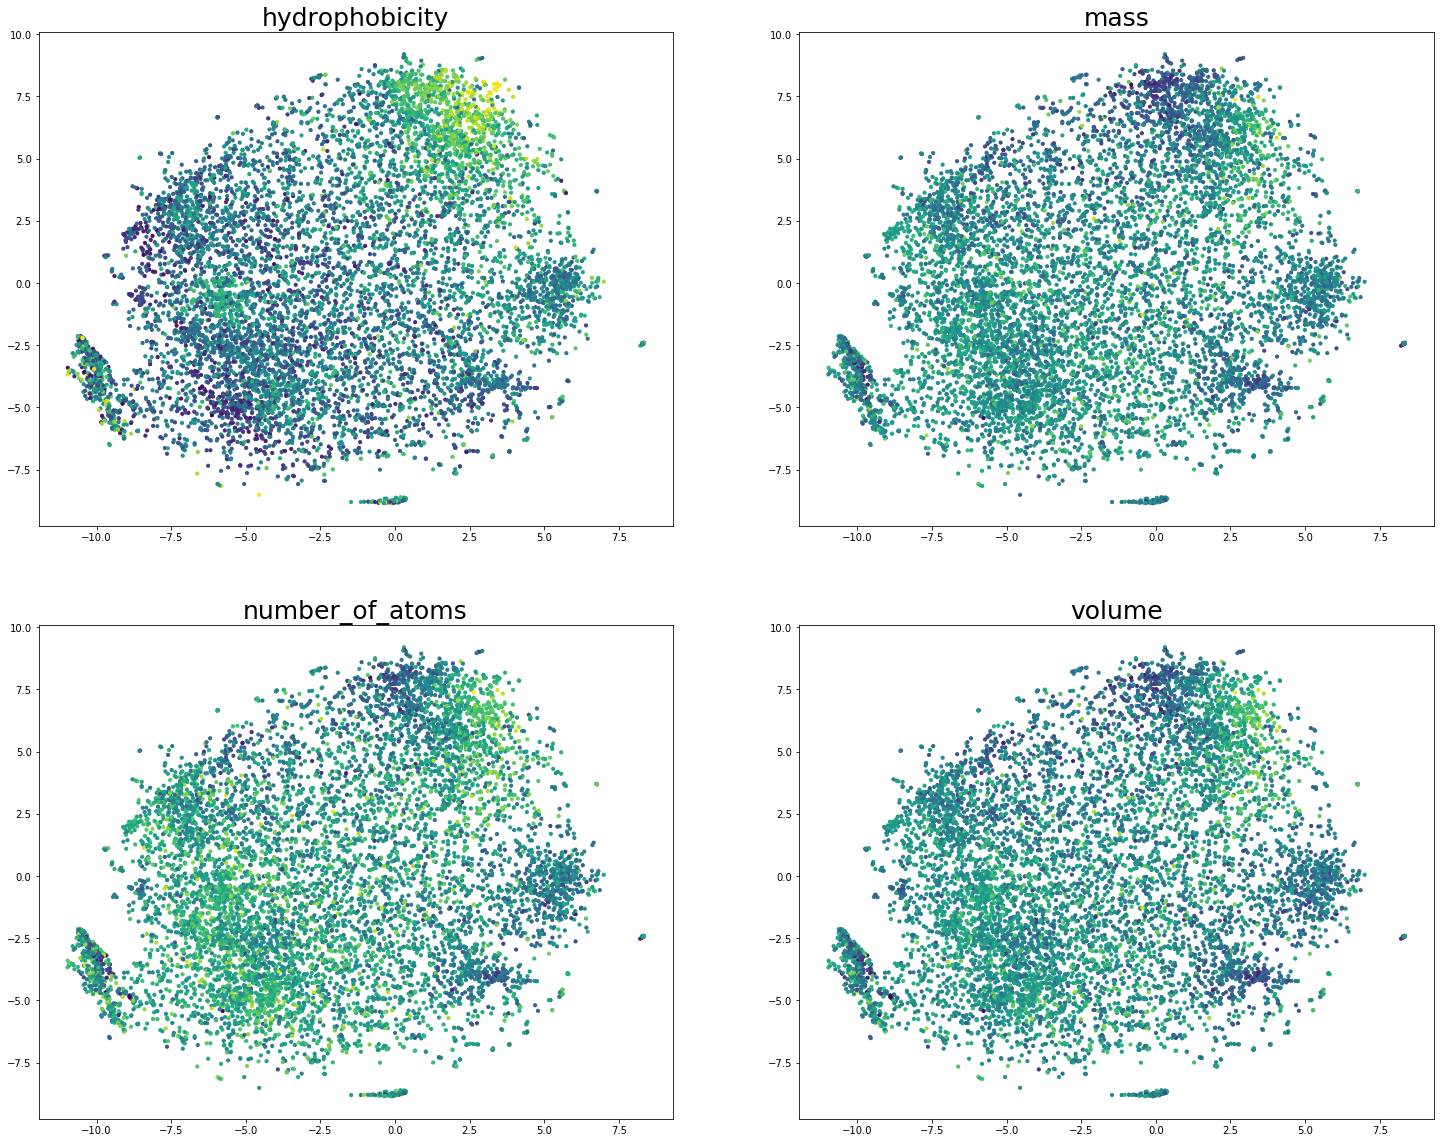

In [65]:
plot_embedding_properties(final_df_nice)